# **Parking slot prediction**

Welcome to my Automated Parking Slot Assignment project! This Google Colab notebook demonstrates a system that combines computer vision and machine learning to automate the process of parking slot assignment in a parking lot. Here's a brief overview of what this project accomplishes:

**Objectives:**
- Detects and identifies parking slots as either "empty" or "occupied" in real-time using the YOLOv8 object detection model.
- Allows users to input car information, such as car ID.
- Assigns an available parking slot to the incoming car based on predefined criteria.
- Displays the results visually by annotating parking slot IDs on the images.

**Key Components:**

- *Object Detection*: It was developed based on the pre-trained YOLOv8 model to detect parking slots in real-world images. The model provides bounding boxes, labels, and probabilities for each detected slot.

- *Parking Slot Management*: It manages a dictionary of parking slots, including their states (empty/occupied), probabilities, and car IDs. Slots are assigned based on parking availability.

- *Visual Annotation*: It automatically annotates parking slot IDs on the images, making it easy to visualize the results.

**Model Training:**

- This model is currently trained for 3 different parking slots with slot ID's being labelled during training process. It can predict the empty slot of these parking spaces at any given point of time and also under different climatic conditions.
- It can be easily expanded and trained on custom parking spaces with slot ID labels.
- As of now, this model takes the snapshot of the parking lot at a given time as an input and predicts the empty slots in that parking area.

**How to Use:**

To use this notebook, simply follow the provided code and instructions. You'll be prompted to input car information and witness the automated parking slot assignment process.

**Sample images of the three parking spaces:**

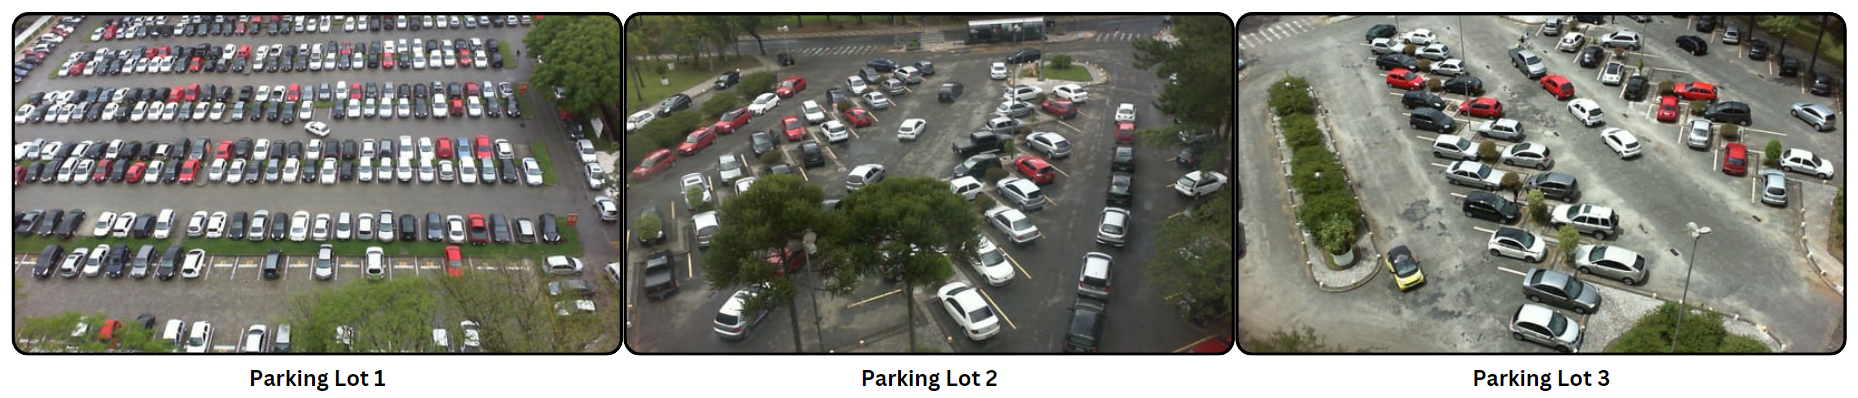

**Note:** Recommended to use Google Colab

Run these cells before launching the user interface.

In [ ]:
# Install the required packages
!pip install ultralytics
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.0/618.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.3 MB/s eta 0

In [ ]:
# Import the packages
import gradio as gr
from ultralytics import YOLO

In [ ]:
import random
from PIL import Image, ImageDraw

In [ ]:
# Load the trained model
model = YOLO("/content/Car_Model.pt")

In [ ]:
# Function to process the image and assign a parking slot based on car_id and slot data
def find_slot_ids(result):
    # Define a dictionary to store parking slot IDs
    parking_slot_id = {}

    for idx, box in enumerate(result.boxes):
        label = result.names[box.cls[0].item()]
        coords = [round(x) for x in box.xyxy[0].tolist()]
        prob = round(box.conf[0].item(), 4)

        # Display the detected object, coordinates, and probability
        # print(f"Parking slot {idx + 1}:\nLabel: {label}\nCoordinates: {coords}\nProbability: {prob}")

        parking_id = idx + 1

        # Store the parking ID in the dictionary
        parking_slot_id[idx] = {
            'label': label,
            'coordinates': coords,
            'probability': prob,
            'parking_id': parking_id,
            'car_id': None
        }
    return parking_slot_id

In [ ]:
# Function to find an empty parking slot
def find_empty_parking_slot(parking_slots):
    empty_slots = [slot_id for slot_id, slot_info in parking_slots.items() if slot_info['label'] == 'empty' and slot_info['probability'] >= float(0.85)]
    if empty_slots:
        return random.choice(empty_slots)
    else:
        return f"Parking Full!"

In [ ]:
def annotate_image(image, parking_slot_ids):
    # Create a drawing context
    draw = ImageDraw.Draw(image)

    # Loop through parking_slot_ids and draw IDs on the image
    for slot_id, slot_info in parking_slot_ids.items():
        x1, y1, x2, y2 = slot_info['coordinates']
        x_center = (x1 + x2) / 2
        y_center = (y1 + y2) / 2
        parking_id = slot_info['parking_id']

        # Draw the parking ID on the image
        text = f"ID: {parking_id}"
        text_x = int(x_center - 1)
        text_y = int(y_center - 3)

        draw.text((text_x, text_y), text, fill=(500, 250, 0))

    # Output image with parking spaces
    return image

In [ ]:
parking_slot_ids = {}

# Define a function to assign a parking slot
def assign_parking_slot(image, car_id):
    # Use the model to find the parking slots in the image
    results = model.predict(image)
    result = results[0]
    output_image = Image.fromarray(result.plot()[:, :, ::-1])

    try:
        # Process the image and assign a parking slot based on car_id and slot data
        parking_slot_ids = find_slot_ids(result)

        # Find an empty parking slot
        empty_slot_id = find_empty_parking_slot(parking_slot_ids)

        # Annotate the image with parking slot IDs
        annotated_image = annotate_image(output_image, parking_slot_ids)

        # Return the annotated image and the assigned parking slot ID
        if empty_slot_id is not None:
            # Label the empty parking slot as occupied
            parking_slot_ids[empty_slot_id]['label'] = 'occupied'
            parking_slot_ids[empty_slot_id]['car_id'] = car_id
            return annotated_image, empty_slot_id
        else:
            return annotate_image, empty_slot_id

    except Exception as e:
        return None, str(e)


In [ ]:
# Gradio interface setup
output_image = gr.outputs.Image(type="pil", label="Annotated Image")
output_slot_id = gr.outputs.Label(type="int", label="Assigned Slot ID")

gr.Interface(
    fn=assign_parking_slot,
    inputs=[gr.Pil(label="Image of paking lot"), gr.Textbox(label="Car ID")],
    outputs=[output_image, output_slot_id],
    title="Automated Parking Slot Assignment",
    description="Upload an image of the parking lot, enter your Car ID, and get the assigned parking slot and annotated image.",
).launch(share=True, debug=True)

<ipython-input-9-81a2add9a097>:2: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  output_image = gr.outputs.Image(type="pil", label="Annotated Image")
<ipython-input-9-81a2add9a097>:3: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  output_slot_id = gr.outputs.Label(type="int", label="Assigned Slot ID")
<ipython-input-9-81a2add9a097>:3: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'int'}
  output_slot_id = gr.outputs.Label(type="int", label="Assigned Slot ID")


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://2545cce6c59441b590.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)



0: 384x640 17 emptys, 23 occupieds, 499.5ms
Speed: 23.8ms preprocess, 499.5ms inference, 25.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 emptys, 23 occupieds, 470.8ms
Speed: 3.4ms preprocess, 470.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://2545cce6c59441b590.gradio.live


In [ ]:
!gradio deploy

Need 'write' access token to create a Spaces repo.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: Traceback (most recent call last):
  File "/usr/lib/python3.10/getpass.py", line 77, in unix_getpass
    passwd = _raw_input(prompt, stream, input=input)
  File "/usr/lib/python3.10/getpass.py", line 146, in _raw_input
    line = input.readline()
KeyboardInter

In [ ]:
"""
After assigning IDs to all detected slots, we can save the results to a file or perform further processing.
For example, you can save the parking_slot_ids dictionary to a JSON file for future reference.
"""

import json

output_file = 'parking_slot_detials.json'
with open(output_file, 'w') as json_file:
    json.dump(parking_slot_ids, json_file, indent=4)

print(f"Parking slot IDs have been saved to '{output_file}'")